In [51]:
from utils.database_connection import DatabaseConnection
import utils.results_repository as rep
import pandas as pd
import numpy as np
from utils.column_name_utils import *
import utils.query_utils as query
import matplotlib.pyplot as plot
import utils.dataframe_utils as df_util
import utils.path_utils as path_util
import utils.math_utils as math_util
import math
import utils.latex_utils as tex
from scipy import stats
import utils.time_series_utils as ts_util
import json
import utils.measurement_utils as m_util

In [52]:
db = DatabaseConnection()

Connected to MySQL Server version  8.0.32-24


In [53]:
# exp_name = 'clang'
# exp_name = 'run_many_clamp'
exp_name = 'app'

In [54]:
used_dut_name = [
    'workstationtwo',
    # 'workstationone',
]

used_dut_name.sort()

used_dut_env = 'prod'

windows = "win32nt"
linux = "unix"

used_os_names = [
    windows, 
    # linux
]

used_test_case_names = [
    'fannkuch-redux.exe',
    # 'mandelbrot.exe',
    # 'idle-case.exe'
]

used_test_case_names.sort()

used_thread = [
    'multi-threaded'
]

used_thread.sort()

used_test_case_name = 'idle-case.exe'

ipg = "ipg"
lhm = "lhm"
rapl = "rapl"
clamp = "clamp"
plug = "plug"
scaphandre = "scaphandre"

windows_mi = [
    ipg, lhm, clamp, plug, scaphandre
]

linux_mi = [
    rapl, clamp, plug
]

used_mi_names = [
    ipg ##ipg, lhm, ipg, clamp, plug #, scaphandre, # plug, rapl
    # clamp ##ipg, lhm, ipg, clamp, plug #, scaphandre, # plug, rapl
]

ipg_sample_rate = 100
lhm_sample_rate = 100
rapl_sample_rate = 100
clamp_sample_rate = 100
plug_sample_rate = 200
scaphandre_sample_rate = 100

used_min_temp = 0
used_max_temp = 200
used_burn_in = 1
used_allocated_cores = [
    []
]
used_compilers = [
    'clang'
    # 'intel-one-api'
]

test_case_parameters = ["", "12", "16000", "64000"]

# experiment_name = "run-clamp-many-times-exp"
# experiment_name = "same-one-api-compiler-different-measuring-instruments-post-update-and-watt"
experiment_name = "same-cpp-multi-core-micro-benchmark-different-compiler"
experiment_number = 1
# experiment_number = 2

used_allocated_cores.sort()
used_mi_names.sort()
used_compilers.sort()

In [55]:
if exp_name == 'clang':
    experiment_name = "same-cpp-multi-core-micro-benchmark-different-compiler"
    experiment_number = 1
    used_compilers = [
        'clang'
    ]
    used_mi_names = [
        ipg
    ]
    used_os_names = [
        windows, 
    ]

    used_test_case_names = [
        'fannkuch-redux.exe',
    ]
    used_dut_name = [
        'workstationone',
    ]

In [56]:
if exp_name == 'run_many_clamp':
    # experiment_name = "same-one-api-compiler-different-measuring-instruments-post-update-and-watt"
    experiment_name = "run-clamp-many-times-exp"
    experiment_number = 2
    used_compilers = [
        'intel-one-api'
    ]
    used_mi_names = [
        # lhm
        # plug
        clamp
    ]
    used_os_names = [
        windows, 
    ]

    used_test_case_names = [
        'mandelbrot.exe',
    ]
    used_dut_name = [
        'workstationtwo',
    ]

In [57]:
if exp_name == 'app':
    experiment_name = "same-mi-different-application-post-config-update"
    experiment_number = 3
    used_burn_in = 0
    
    used_test_case_name = 'idle.exe'
    
    used_os_names = [
        windows, 
    ]
    
    used_mi_names = [
        ipg, clamp
    ]
    
    used_compilers = [
        'unkown'
    ]
    
    used_test_case_names = [
        '3d-mark.exe',
        # 'idle.exe'
    ]
    
    used_thread = [
        'multi-threaded'
    ]
    
    used_allocated_cores = [
        # ['4'],
        # ['4', '3'],
        # ['4', '3', '2'],
        # ['4', '3', '2', '1'],
        # ['4', '3', '2', '1', '5'],
        # ['4', '3', '2', '1', '5', '0'],
        # ['4', '3', '2', '1', '5', '0', '8'],
        # ['4', '3', '2', '1', '5', '0', '8', '7'],
        ['4', '3', '2', '1', '5', '0', '8', '7', '6'],
        # ['4', '3', '2', '1', '5', '0', '8', '7', '6', '9'],
        
        # ['0']
        # ['0', '5']
        # ['0', '5', '6']
        # ['0', '5', '6', '2']
        # ['0', '5', '6', '2', '4']
        # ['0', '5', '6', '2', '4', '3']
        # ['0', '5', '6', '2', '4', '3', '1']
        # ['0', '5', '6', '2', '4', '3', '1', '7']
    ]
    
    idle_case_config = 2
    
    used_os_names = [
        windows
    ]   
    
    test_case_parameters = [""]

In [58]:
used_dut_name_str = "','".join(used_dut_name)
used_os_name_str = "','".join(used_os_names)
dut = rep.get_devices_under_test(db)
dut.shape

(9, 4)

In [59]:
used_dut = dut.query(f"{ENV} == '{used_dut_env}' and {NAME} in ('{used_dut_name_str}') and Os in ('{used_os_name_str}')")
used_dut.shape

(1, 4)

In [60]:
tc = rep.get_test_cases(db)
tc.shape

(32, 8)

In [61]:
used_test_case_name_str = "','".join(used_test_case_names)
used_compiler_str = "','".join(used_compilers)
used_thread_str = "','".join(used_thread)
used_test_case_parameters = "','".join(test_case_parameters)

used_tc = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} in ('{used_test_case_name_str}') and {THREADS} in ('{used_thread_str}') and Parameter in ('{used_test_case_parameters}')")

In [62]:
used_idle_case = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} == '{used_test_case_name}' and {THREADS} in ('{used_thread_str}')")

In [63]:
mi = rep.get_measuring_instruments(db)

mi.shape

(15, 3)

In [64]:
used_mi_query_list =  query.get_mi_query(
    used_mi_names,
    ipg,
    lhm,
    rapl,
    plug,
    clamp,
    scaphandre,
    ipg_sample_rate,
    lhm_sample_rate,
    rapl_sample_rate,
    plug_sample_rate,
    clamp_sample_rate,
    scaphandre_sample_rate,
)

used_mi = mi.query(" or ".join(used_mi_query_list))

In [65]:
used_allocated_cores_str = ",".join([str(x) for x in used_allocated_cores])
used_allocated_cores_str = used_allocated_cores_str.replace("'", '')
used_allocated_cores_str = used_allocated_cores_str.replace("[", "'[")
used_allocated_cores_str = used_allocated_cores_str.replace("]", "]'")

In [66]:
config = rep.get_configurations(db)

config.shape

(32, 5)

In [67]:
config.shape

(32, 5)

In [68]:
used_configs = config.query(f"{MIN_TEMP} == {used_min_temp} and " +
                            f"{MAX_TEMP} == {used_max_temp} and " +
                            f"{BURN_IN} == {used_burn_in} and " +
                            f"{ALLOCATED_CORES} in ({used_allocated_cores_str})")
used_configs

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
17,18,0,200,0,"[4, 3, 2, 1, 5, 0, 8, 7, 6]"


In [69]:
exp = rep.get_distinct_experiments(db)

exp.shape

(11, 2)

In [70]:
data_to_plot = {}
data_to_plot_watt = {}
data_to_plot_total = {}

for i in range(5, 51, 5):
    print(i)
    cpu_energy_results = {}
    dram_energy_results = {}
    gpu_energy_results = {}
    duration_results = {}

    idle_cpu_consumption_results = {}

    cpu_dynamic_energy_watt_consumption = {}

    cpu_dynamic_energy_consumption = {}
    gpu_dynamic_energy_consumption = {}
    dram_dynamic_energy_consumption = {}

    temperature_begin = {}
    temperature_end = {}

    m_util.get_measurements(
        windows,
        windows_mi,
        linux,
        linux_mi,
        used_configs,
        used_dut,
        used_mi,
        used_tc,
        used_idle_case,
        db,
        experiment_name,
        experiment_number,
        # energy_per_time,
        scaphandre,
        cpu_energy_results,
        dram_energy_results,
        gpu_energy_results,
        duration_results,
        temperature_begin,
        temperature_end,
        cpu_dynamic_energy_consumption,
        gpu_dynamic_energy_consumption,
        dram_dynamic_energy_consumption,
        idle_cpu_consumption_results,
        used_test_case_name,
        cpu_dynamic_energy_watt_consumption,
        idle_case_config=idle_case_config
    )
    
    for key, value in cpu_dynamic_energy_consumption.items():
        cpu_dynamic_energy_consumption[key] = value[:i]
    
    for k in cpu_dynamic_energy_consumption.keys():
        data_to_plot[k + "." +str(i).rjust(5, '0')] = cpu_dynamic_energy_consumption[k]
    
    for key, value in cpu_energy_results.items():
        cpu_energy_results[key] = value[:i]
    
    for k in cpu_energy_results.keys():
        data_to_plot_total[k + "." +str(i).rjust(5, '0')] = cpu_energy_results[k]
    
    for key, value in cpu_dynamic_energy_watt_consumption.items():
        cpu_dynamic_energy_watt_consumption[key] = value[:i]
    
    for k in cpu_dynamic_energy_watt_consumption.keys():
        data_to_plot_watt[k + "." +str(i).rjust(5, '0')] = cpu_dynamic_energy_watt_consumption[k]

5
(1, 8)
Y - 3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6].unkown.ipg.100.34
(1, 8)
Y - 3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6].unkown.clamp.100.34
10
(1, 8)
Y - 3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6].unkown.ipg.100.34
(1, 8)
Y - 3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6].unkown.clamp.100.34
15
(1, 8)
Y - 3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6].unkown.ipg.100.34
(1, 8)
Y - 3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6].unkown.clamp.100.34
20
(1, 8)
Y - 3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6].unkown.ipg.100.34
(1, 8)
Y - 3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6].unkown.clamp.100.34
25
(1, 8)
Y - 3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6].unkown.ipg.100.34
(1, 8)
Y - 3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6].unkown.clamp.100.34
30
(1, 8)
Y - 3d-mark.exe.win32nt.workstationtwo.[4, 3, 

In [71]:
def convert_to_series(df):
    for key in df.keys():
        df[key] = pd.Series(df[key])
    return df

In [72]:
data_to_plot = convert_to_series(data_to_plot)
data_df = pd.DataFrame(data_to_plot)
data_df = data_df.reindex(columns=sorted(data_df.columns))

data_to_plot_watt = convert_to_series(data_to_plot_watt)
data_df_watt = pd.DataFrame(data_to_plot_watt)
data_df_watt = data_df_watt.reindex(columns=sorted(data_df_watt.columns))

data_to_plot_total = convert_to_series(data_to_plot_total)
data_df_total = pd.DataFrame(data_to_plot_total)
data_df_total = data_df_total.reindex(columns=sorted(data_df_total.columns))


In [73]:
data_df_total.shape

(44, 20)

Watt of Test Case


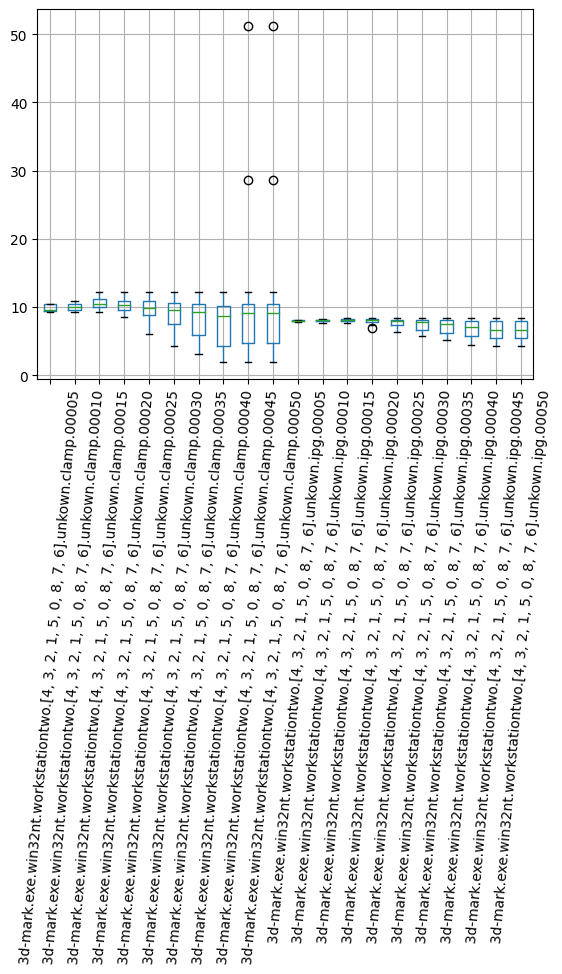

Joules of Test Case


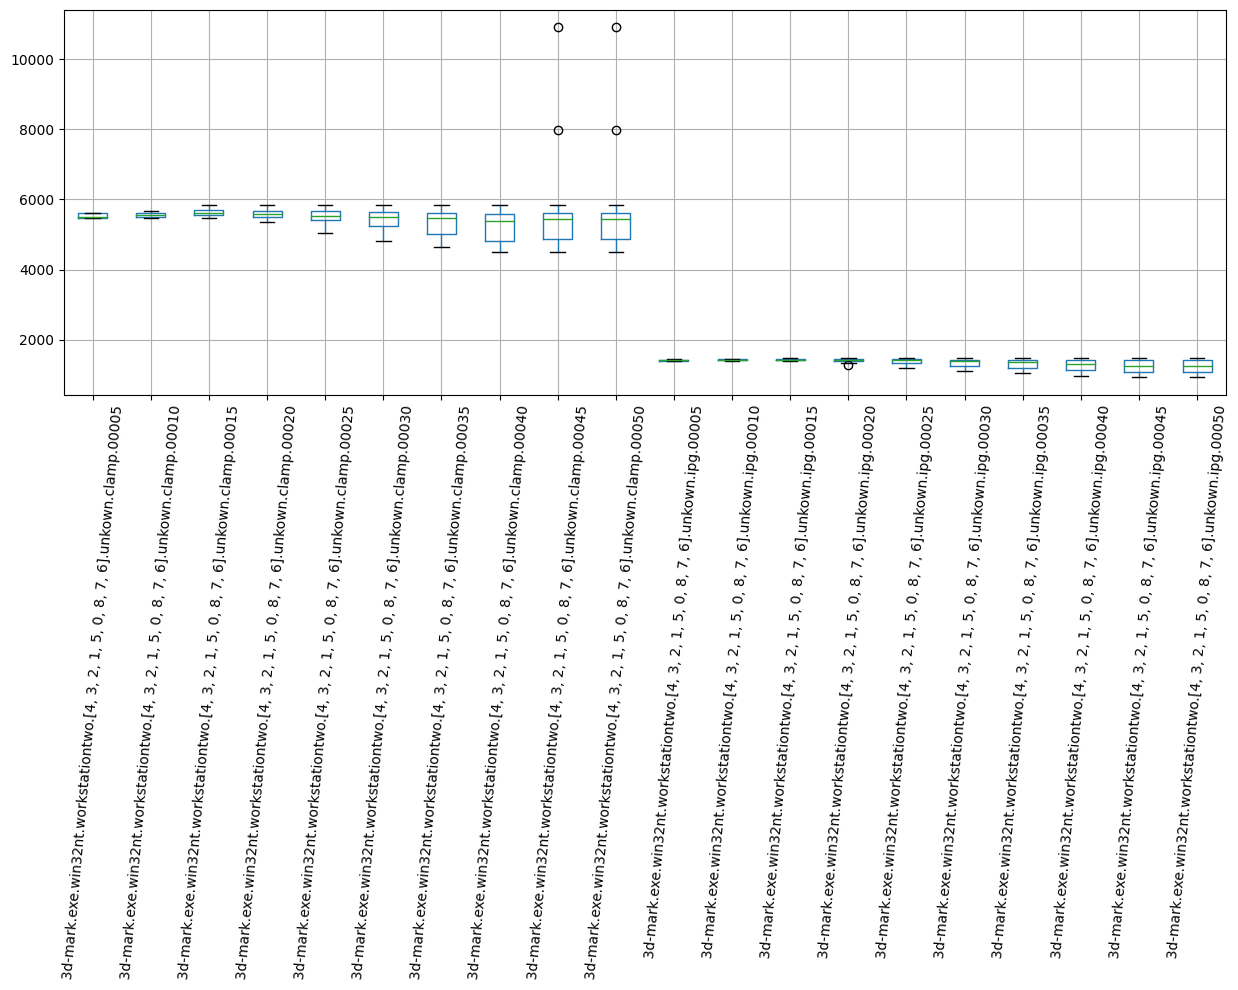

Joules of Test Case


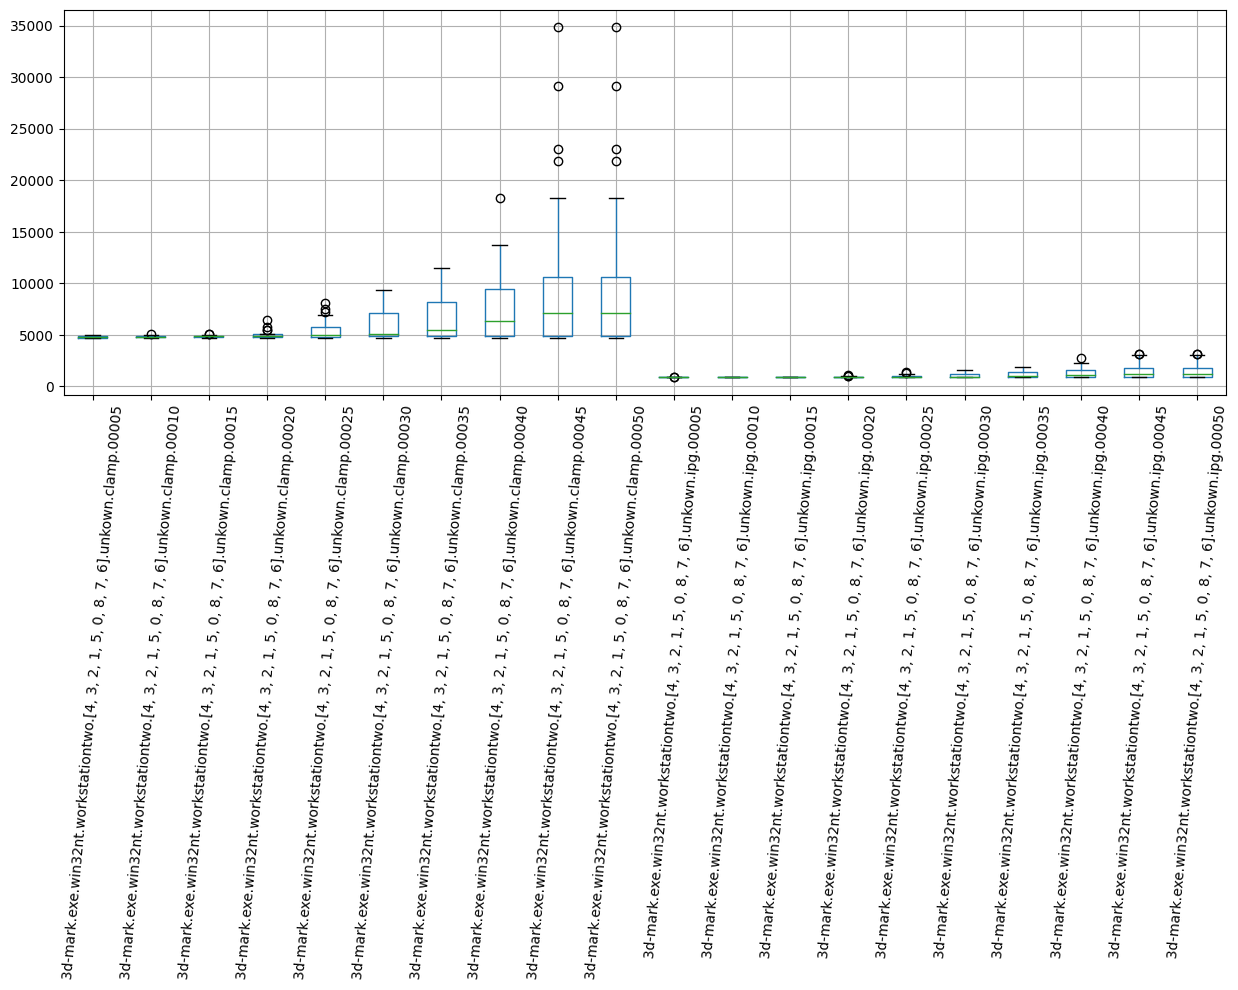

In [77]:
plot.clf()



print("Watt of Test Case")
boxplot_watt = data_df_watt.boxplot(figsize=(15,5), rot=85)
boxplot_watt.plot()
# plot.ylim(0,1300)
plot.show()

print("Joules of Test Case")
boxplot = data_df.boxplot(figsize=(15,5), rot=85)
boxplot.plot()
# plot.ylim(0,1000)
plot.show()

print("Joules of Test Case")
boxplot = data_df_total.boxplot(figsize=(15,5), rot=85)
boxplot.plot()
# plot.ylim(0,1000)
plot.show()

In [75]:
def  remove_outliers_z_score(df, column, limit):
    z_score = pd.Series(np.abs((df[column] - df[column].mean()) / df[column].std()))

    # identify outliers as data points with z-score > 3
    outliers = df[column][z_score > limit]
    # df = df.drop('z_score', axis=1)
    
    return [
        x for x in list(df[column]) if x not in list(outliers)
    ]

def remove_n_percent(df, column, percent):
    data_to_order = df[column]

    list(data_to_order).sort()
    data_to_order = [x for x in data_to_order if str(x) != 'nan']
    data_to_order
    percent = 20

    n = len(data_to_order)
    outliers = int(n*percent/100) #may want some rounding logic if n is small
    trimmed_data = data_to_order[outliers: n-outliers]
    
    return trimmed_data

In [76]:
# last_k_df = pd.DataFrame({"data" : list(data_df_watt['mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.03000'])[2500:]})

KeyError: 'mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.03000'

,0,1,2,3,4
,with,without,z,z - n,count
"3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6].unkown.clamp.00005",1060.6,1060.6,25.4,37.8,5.0
"3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6].unkown.clamp.00010",1072.2,1072.2,224.7,252.2,10.0
"3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6].unkown.clamp.00015",3307.4,3307.4,938.4,406.4,15.0
"3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6].unkown.clamp.00020",4127.5,4127.5,1292.0,661.8,20.0
"3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6].unkown.clamp.00025",9469.5,9469.5,2767.9,1497.3,25.0
"3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6].unkown.clamp.00030",20642.4,20642.4,5064.9,2888.0,30.0
"3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6].unkown.clamp.00035",32428.0,32428.0,12067.2,6554.1,35.0
"3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6].unkown.clamp.00040",40381.5,40381.5,13355.6,14114.7,40.0
"3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6].unkown.clamp.00045",254575.5,39916.7,39916.7,11806.4,44.0


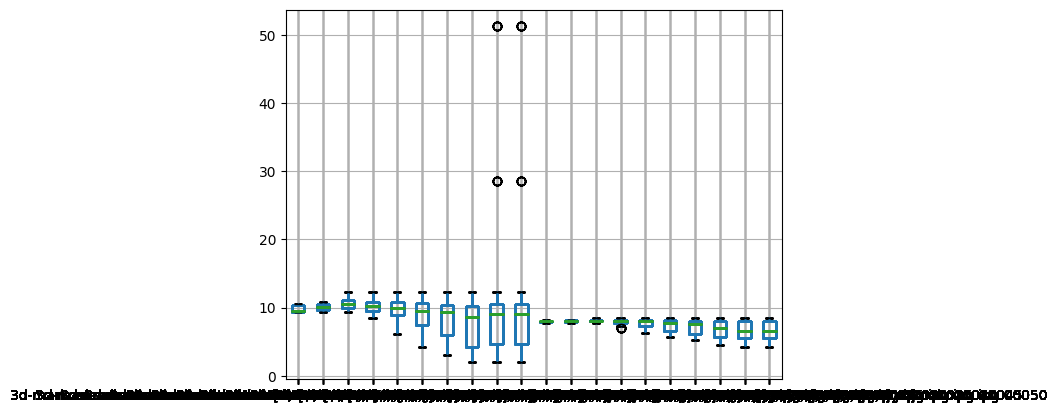

In [78]:
cochrans_data = {
    "" : ["with", "without", 'z', 'z - n', "count"]
}

Z = 1.96
E = 0.03

include_outliers = False

# used_df = last_k_df
used_df = data_df_watt

# for column in last_k_df.columns:
for column in used_df.columns:
    # print(column)
    used_df_without_outlisers = math_util.exclude_outliers(used_df, column)
    used_df_without_z_score_outliers = remove_outliers_z_score(used_df, column, 1)
    
    used_df_without_n_percent = remove_n_percent(used_df, column, 20)
    used_df_without_n_percent = pd.DataFrame({column : used_df_without_n_percent})
    used_df_without_z_and_n_score_outliers = remove_outliers_z_score(used_df_without_n_percent, column, 1)
    
    current_count = used_df[column].count()
    
    values = used_df_without_outlisers
    n_zero_without = math_util.get_cochran(values, Z, E)
    
    values = used_df_without_z_score_outliers
    n_zero_without_z_outliers = math_util.get_cochran(values, Z, E)
    
    values = used_df_without_z_and_n_score_outliers
    n_zero_without_z_and_n_outliers = math_util.get_cochran(values, Z, E)
    
    values = list(used_df[column])
    n_zero = math_util.get_cochran(values, Z, E)
    
    cochrans_data[column] = [round(n_zero, 1), round(n_zero_without, 1),  round(n_zero_without_z_outliers, 1), round(n_zero_without_z_and_n_outliers, 1), current_count]
    # cochrans_data[column] = [round(n_zero, 1), round(n_zero_without, 1),  round(n_zero_without_z_outliers, 1), current_count]

pd.DataFrame(cochrans_data).T

In [ ]:
cochrans_data

{'': ['with', 'without', 'z', 'z - n', 'count'],
 'mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00200': [18754.6,
  4524.3,
  3330.7,
  3320.1,
  200],
 'mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00400': [20035.9,
  4343.4,
  3289.4,
  2902.1,
  400],
 'mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00600': [24428.9,
  8513.1,
  5451.9,
  3990.7,
  600],
 'mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00800': [38268.2,
  23274.6,
  11309.8,
  6833.6,
  800],
 'mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.01000': [38959.8,
  31855.8,
  12467.6,
  11178.5,
  1000],
 'mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.01200': [36964.0,
  26106.6,
  11531.0,
  9981.4,
  1200],
 'mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.01400': [35660.9,
  24753.6,
  10903.7,
  9914.7,
  1400],
 'mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.01600': [35545.1,
  23469.0,
  1038

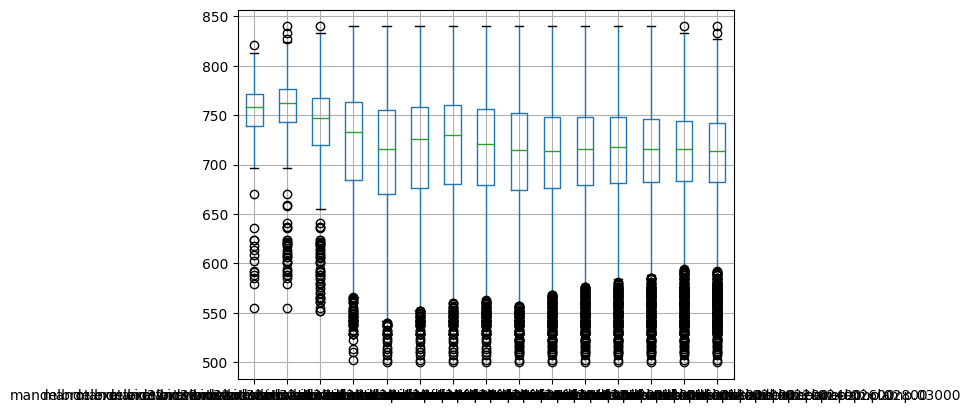

In [ ]:

_, box_plot_data = data_df.boxplot(return_type="both")
medians = [median.get_ydata() for median in box_plot_data["medians"]]

In [ ]:
medians

[array([757.8874785, 757.8874785]),
 array([762.68010938, 762.68010938]),
 array([747.16258942, 747.16258942]),
 array([733.12995539, 733.12995539]),
 array([715.75000859, 715.75000859]),
 array([725.59572751, 725.59572751]),
 array([730.11409047, 730.11409047]),
 array([721.33773333, 721.33773333]),
 array([715.14082681, 715.14082681]),
 array([713.79839067, 713.79839067]),
 array([716.26858338, 716.26858338]),
 array([717.40732465, 717.40732465]),
 array([716.16715148, 716.16715148]),
 array([715.93938116, 715.93938116]),
 array([713.6509708, 713.6509708])]

In [ ]:
first_median = medians[0][0]
second_last_median = medians[-2][0]
last_median = medians[-1][0]

In [ ]:
first_median, last_median, second_last_median

(757.8874784997041, 713.650970803521, 715.9393811623461)

In [ ]:
(last_median / first_median) * 100

94.16318266878446

In [ ]:
box_plot_raw_data = [
    {
        # "data" : data_df,
        # "name" : "CPU",
        # "data_type" : "energy consumption",
        # "width" : 0.9,
        # "xmin" : 0,
        # "xmax" : 900,
        # "xlabel" : "Total Energy Consumption (Joules)"
    }
]

In [ ]:
for plot_data in box_plot_raw_data:
    print("start")
    data = plot_data["data"]
    width = plot_data["width"]
    height = 0.1 + (len(data.columns) * 0.02)
    xmin = plot_data["xmin"]
    xmax = plot_data["xmax"]
    xlabel = plot_data["xlabel"]
    
    latex_boxes = tex.get_boxes(data)
    plot.clf()
    # latex_boxes = tex.get_boxes(pd.DataFrame(data['fannkuch-redux.exe.ipg.workstationone.all.intel-one-api.win32nt']))
    
    title = f"The evolution of energy consumption"
    
    
    ytick = str(list(range(1, len(list(data.columns))+1))).replace('[', '').replace(']', '')
    
    yticklables = [
        # '100',
        # '200',
        # '300',
        # '400',
        # '500',
        # '600',
        # '700',
        # '800',
        # '900',
        # '1000'
        '200, '
        '400, '
        '600, '
        '800, '
        '1000, '
        '1200, '
        '1400, '
        '1600, '
        '1800, '
        '2000, '
        '2200, '
        '2400, '
        '2600, '
        '2800, '
        '3000, '
    ]
    
    labels = f"evolution_of_medians".lower()
    
    caption = "A visual representation of how the energy measurements evolve as more measurements are made by clamp on DUT 2 for test case MB"
    
    latex_box_plot = tex.get_boxplot_template(width, height, xlabel, title, ytick, yticklables, xmin, xmax, latex_boxes, caption, labels)

    box_plot_path = f"evolution"
    box_plot_file_name = f"evolution.tex"
    print(f"generating {box_plot_file_name}")
    # print(data)
    path_util.write_to_path(box_plot_path.replace('.exe', ''), box_plot_file_name, latex_box_plot)

start
generating evolution.tex


<Figure size 640x480 with 0 Axes>